<a href="https://colab.research.google.com/github/zhuofachen/Raman_deep_learning/blob/main/machine_learning_models_applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import random
import collections

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
import time
import multiprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Hyperparameters
hps = {
    'seed': 42,
    'augment': True
}

# Dataset

In [ ]:
def load_file(filename):
    file = open(filename) 

    lines = file.readlines()
        
    data = []
    for line in lines:
        arr = []
        for num in line.split(","):
            arr.append(float(num))
        data.append(arr)

    return np.array(data)

def data_augment(spectra, augmentation, noiselevel, apply_peak_shift):
    
    spectra_augment = np.empty(spectra.shape, dtype=float, order='C')    
    for idx in range(len(spectra)):
        spec = spectra[idx].reshape(1, -1)
        max_Intensity = np.max(spec, axis = 1)
        if augmentation:
            if random.uniform(0, 1) > 0: # noise
                noise = np.random.normal(0, max_Intensity * noiselevel, spec.shape[1]).astype(np.float32)
                spec = spec + noise  
            if apply_peak_shift:
                if random.uniform(0, 1) > 0.5:   # Shift
                    temp = np.zeros(spec.shape).astype(np.float32)
                    shift_count = np.random.randint(1, 30)

                    if random.uniform(0, 1) > 0.5:   # Shift right
                        temp[:, shift_count:] = spec[:, :-shift_count]
                    else:
                        temp[:, :-shift_count] = spec[:, shift_count:]                
                    spec = temp
        spec = spec.astype(np.float32)
        spec = spec.flatten()
        spec = spec/max_Intensity
        spectra_augment[idx] = spec
    return spectra_augment

In [ ]:
# Load data
Y = []
data = []
   
# path = 'datasets/dielectric_dataset/'
# for i in range(4):
#     curr_data = load_file(path + "dielectric" + str(i) + ".txt")    
#     data.append(curr_data)
#     count = len(curr_data)
#     Y.extend([i] * count)

path = 'datasets/charge_dataset/'
for i in range(4):
    curr_data = load_file(path + "c" + str(i) + ".txt")    
    data.append(curr_data)
    count = len(curr_data)
    Y.extend([i] * count)



X = np.vstack(data)
Y = np.array(Y)

count = collections.defaultdict(int)
for num in Y:
    count[num] += 1

classes_count = len(count.keys())
print("Total number of smaples: ")
print(sum(v for v in count.values()))
for i in sorted(count.keys()):
    print("Class", i, "Count:", count[i])



Total number of smaples: 
2112
Class 0 Count: 484
Class 1 Count: 633
Class 2 Count: 753
Class 3 Count: 242


# Machine learning algorithms.

In [ ]:
# Machine learning algorithms. 

def KNN(xtrain, ytrain, xtest, ytest):
    classifier = KNeighborsClassifier(n_neighbors= 7, p = 4)
    classifier.fit(xtrain, ytrain)
    ypred = classifier.predict(xtest)
    accuracy = accuracy_score(ytest, ypred)
    return accuracy

def decision_tree(xtrain, ytrain, xtest, ytest, rs = 0):
    classifier = DecisionTreeClassifier(criterion = "entropy", 
            max_depth = 3, min_samples_leaf = 0.1, min_samples_split = 0.1, random_state = rs) 
    classifier.fit(xtrain, ytrain)
    ypred = classifier.predict(xtest)
    accuracy = accuracy_score(ytest, ypred)
    return accuracy

def SVM(xtrain, ytrain, xtest, ytest, rs = 0):
    svm_model = SVC(kernel = 'rbf', C = 27, random_state = rs).fit(xtrain, ytrain)    
    accuracy = svm_model.score(xtest, ytest) 
    return accuracy

def naive_bayes(xtrain, ytrain, xtest, ytest):
    gnb = GaussianNB(var_smoothing = 5).fit(xtrain, ytrain) 
    accuracy = gnb.score(xtest, ytest)  
    return accuracy


def random_forest(xtrain, ytrain, xtest, ytest, rs = 0):
    randomForest = RandomForestClassifier(n_estimators=300, max_depth=7)
    randomForest.fit(xtrain, ytrain)
    ypred = randomForest.predict(xtest)  
    accuracy = accuracy_score(ytest, ypred)
    return accuracy

# Training without noise variation

In [ ]:
accuracy =[]
dup = 100
for i in range(dup):
    tmp = []
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, train_size=0.8, shuffle=True)
    xtrain = data_augment(xtrain, augmentation=False, noiselevel = 0, apply_peak_shift=False)
    xtest = data_augment(xtest, augmentation= False, noiselevel = 0, apply_peak_shift=False)
    knn = KNN(xtrain, ytrain, xtest, ytest)     
    dt = decision_tree(xtrain, ytrain, xtest, ytest)       
    svm = SVM(xtrain, ytrain, xtest, ytest)   
    nb = naive_bayes(xtrain, ytrain, xtest, ytest)     
    rf = random_forest(xtrain, ytrain, xtest, ytest)
    tmp = [svm, rf, knn, dt, nb]
    accuracy.append(tmp)


[0.99901497 0.98739165 0.9858156  0.94483846 0.46513002]
[0.00151323 0.00620489 0.00570976 0.01206729 0.00399392]


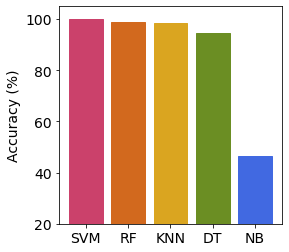

[[1.0, 0.983451536643026, 0.983451536643026, 0.933806146572104, 0.47044917257683216], [1.0, 0.9929078014184397, 0.9905437352245863, 0.9550827423167849, 0.4657210401891253], [1.0, 0.9858156028368794, 0.9810874704491725, 0.9361702127659575, 0.4657210401891253], [1.0, 0.9976359338061466, 0.9976359338061466, 0.9527186761229315, 0.46808510638297873], [0.9976359338061466, 0.9810874704491725, 0.9858156028368794, 0.9598108747044918, 0.4657210401891253], [0.9952718676122931, 0.9858156028368794, 0.9787234042553191, 0.9408983451536643, 0.46099290780141844], [1.0, 0.9905437352245863, 0.9858156028368794, 0.9385342789598109, 0.4657210401891253], [1.0, 0.9763593380614657, 0.9881796690307328, 0.9196217494089834, 0.4562647754137116], [1.0, 0.9810874704491725, 0.983451536643026, 0.9385342789598109, 0.46099290780141844], [0.9976359338061466, 0.9858156028368794, 0.9858156028368794, 0.9479905437352246, 0.46335697399527187], [1.0, 0.9929078014184397, 0.9929078014184397, 0.9645390070921985, 0.468085106382978

In [ ]:
acc_mean = np.mean(accuracy, axis = 0)
acc_std = np.std(accuracy, axis = 0)
print(acc_mean)
print(acc_std)

# evalute results of different optimized models
models = ['SVM', 'RF', 'KNN', 'DT','NB']
colors = ['#cb416b', 'chocolate', 'goldenrod', 'olivedrab', 'royalblue']
f2 = plt.figure(figsize=(4,4)) 
barlist = plt.bar(models, np.array(acc_mean) * 100)
for i in range(5):
    barlist[i].set_color(colors[i])
plt.legend()
plt.ylim([20, 105])
plt.ylabel("Accuracy (%)")
plt.rcParams.update({'font.size': 14})
plt.show()

# Training with diffferent noise levels

In [ ]:
def train_noise(dup):

    num_iter = 100
    noise = ((dup // num_iter)* 2) * 0.01  # noise level from 0 to 60, with a step of 2
    start = time.time()     
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, train_size=0.8, shuffle=True)
    xtrain = data_augment(xtrain, augmentation=True, noiselevel = noise, apply_peak_shift=False)
    xtest = data_augment(xtest, augmentation= False, noiselevel = 0, apply_peak_shift=False)
    start = time.time() 

    knn = KNN(xtrain, ytrain, xtest, ytest)     
    dt = decision_tree(xtrain, ytrain, xtest, ytest)       
    svm = SVM(xtrain, ytrain, xtest, ytest)   
    nb = naive_bayes(xtrain, ytrain, xtest, ytest)     
    rf = random_forest(xtrain, ytrain, xtest, ytest)
    print("time for training:", time.time() - start)

    tmp = [noise, svm, rf, knn, dt, nb]
    return tmp
   
   

In [ ]:
import multiprocessing


a_pool = multiprocessing.Pool()
# global num_iter
num_iter = 100
maxNoise = 30
dup = num_iter * maxNoise


accuracy_noise =[]
accuracy_noise = a_pool.map(train_noise, range(dup))
a_pool.close()
a_pool.join()



In [ ]:
accs = collections.defaultdict(list)
for l in accuracy_noise:
    accs[l[0]].append(l[1:])
    
ymean = []
ystd = []
noises = sorted(accs.keys())
print(noises)
for noise in noises:
    tmpmean = np.mean(accs[noise], axis = 0)
    tmpstd = np.std(accs[noise], axis = 0)
    ymean.append(np.concatenate((np.array([noise]), tmpmean), axis = 0))
    ystd.append(np.concatenate((np.array([noise]), tmpstd), axis = 0))
    
ymean = np.reshape(np.array(ymean), [len(noises), 6])
ystd = np.reshape(np.array(ystd), [len(noises), 6])
print(ystd.shape)
print(ymean.shape)
print(ymean)
print("print mean values")
print(ystd)
print(num_iter)

[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58]
(30, 6)
(30, 6)
[[0.         0.99822695 0.98730496 0.98619385 0.94565012 0.46737589]
 [0.02       0.99283688 0.95508274 0.98522459 0.92562648 0.46678487]
 [0.04       0.97212766 0.92572104 0.94853428 0.91212766 0.46619385]
 [0.06       0.95049645 0.84361702 0.85172577 0.89427896 0.46591017]
 [0.08       0.92106383 0.73794326 0.78952719 0.87361702 0.46579196]
 [0.1        0.85323877 0.66515366 0.7421513  0.81917258 0.4644208 ]
 [0.12       0.81747045 0.63881797 0.69730496 0.76624113 0.4634279 ]
 [0.14       0.80314421 0.62716312 0.67       0.71073286 0.46234043]
 [0.16       0.81536643 0.62385343 0.62846336 0.65943262 0.46255319]
 [0.18       0.80997636 0.61919622 0.61184397 0.62782506 0.46196217]
 [0.2        0.79108747 0.61338061 0.59560284 0.59522459 0.46186761]
 [0.22       0.76933806 0.60898345 0.56971631 0.55

NameError: name 'num_iter' is not defined

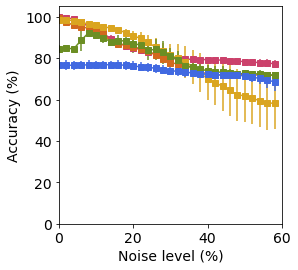

In [ ]:
# plot accuracies versus noise


def plot_acc(noises, ymean, ystd):
#     colors = ['skyblue', 'lightsteelblue', 'wheat', 'mediumaquamarine', 'pink']
#     colors = ['skyblue', 'slategray',  'darkkhaki', 'cadetblue', 'lightsteelblue']   # for deep learning
#     colors = ['#cb416b', 'gray',  'goldenrod', 'olivedrab', 'royalblue',]
    colors = ['#cb416b', 'chocolate', 'goldenrod', 'olivedrab', 'royalblue']
    model_name = ['SVM',  'Random forest', 'KNN', 'Decision Tree', 'Naive Bayes']

    f = plt.figure(figsize=(4,4))
    for i in range(5):
        plt.errorbar(np.array(noises) * 100 , ymean[:, i + 1] * 100, yerr = ystd[:,i + 1] * 100, color=colors[i], fmt='-s', mfc=colors[i], mec=colors[i], ecolor = colors[i],capthick=1,
                 label = model_name[i])
    plt.ylim([0, 105])
    plt.xlim([0, 60])
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Noise level (%)")
    plt.rcParams.update({'font.size': 14})
    plt.legend(loc="lower right") 
    plt.savefig('dielectric_dataset_noiselevel_nopeakshift_plot.png', bbox_inches = 'tight')  
    plt.show()
plot_acc(noises, ymean, ystd)


In [ ]:
s# Get ROC curve and AUC score

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.preprocessing import label_binarize

KNN_classifier = KNeighborsClassifier(n_neighbors= 1, p = 1)
dt_classifier = DecisionTreeClassifier(criterion = "entropy", 
            max_depth = 3, min_samples_leaf = 0.1, min_samples_split = 0.1, random_state = 0) 
svm_classifier = SVC(kernel = 'linear', C = 3, random_state = 0, probability=True)
nb_classifier = GaussianNB(var_smoothing = 0.01)
rt_classifier = RandomForestClassifier(n_estimators=300, random_state = 0)


xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, train_size=0.8, shuffle=True)
y_test = label_binarize(ytest, classes=[0, 1, 2, 3])   # for different charge doping classes
numClasses = len(np.unique(ytest))


In [ ]:

models = [KNN_classifier, svm_classifier, rt_classifier, dt_classifier, nb_classifier]
colors = ['royalblue', 'goldenrod', 'olivedrab', 'chocolate', 'purple']
model_name = ['KNN', 'SVM', 'Random forest', 'Decision Tree', 'Naive Bayes']
all_rates = []
for m in range(5):

    classifier = OneVsRestClassifier(models[m])
    classifier.fit(xtrain, ytrain)
    p_probs = classifier.predict_proba(xtest)
# Compute ROC curve and ROC area for each class

    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(numClasses):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], p_probs[:, i])
        fpr[i] = np.array(fpr[i])
        tpr[i] = np.array(tpr[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_rates.append([fpr, tpr, roc_auc])
    plt.figure
    for i, color in zip(range(numClasses), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of different classes, model: ' + model_name[m])
    plt.legend(loc="lower right")
    plt.show()
# plot different model result ROC of a class

c = 2
print(len(all_rates))
plt.figure
for m in range(5):
    fpr = all_rates[m][0][c]
    tpr = all_rates[m][1][c]
    tmp_auc = all_rates[m][2][c]
    color = colors[m]
    plt.plot(fpr, tpr, color=color, lw=lw,
              label= model_name[m])
plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Random Prediction')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC curves of different classes, model: ' + model_name[m])
plt.legend(loc="lower right")
plt.show()


plt.figure
for m in range(5):
    fpr = all_rates[m][0][c]
    tpr = all_rates[m][1][c]
    tmp_auc = all_rates[m][2][c]
    color = colors[m]
    plt.plot(fpr, tpr, color=color, lw=lw,
              label= model_name[m])
plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Random Prediction')
plt.ylim([0.95, 1.02])
plt.xlim([-0.05, 0.25])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC curves of different classes, model: ' + model_name[m])
plt.legend(loc="lower right")
plt.show()
